# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN

from __future__ import print_function

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

#Set some global options
pd.set_option('max_columns',100) #Its nice to see all columns

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./data/WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./data/WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

## Set I Answer

In [4]:
#First merge the two datasets into one dataframe
df = df_offers.merge(df_transactions, on='offer_id', how='left')

#Then can pivot on n for the offer_id and customer_name
df_responses = df.pivot_table(values='n', index='customer_name', columns='offer_id', fill_value=0)

In [5]:
df.sample(5)

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
77,8,March,Espumante,6,45,South Africa,False,Hill,1
30,4,February,Champagne,72,48,France,True,Sanchez,1
316,31,December,Champagne,72,89,France,False,Price,1
270,29,November,Pinot Grigio,6,87,France,False,Adams,1
239,26,October,Pinot Noir,144,83,Australia,False,Campbell,1


In [6]:
df_responses.sample(5)

offer_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Gomez,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
Collins,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Garcia,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Fisher,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0
Martin,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

## Set II Answers

- Small values of SS should be better since they represent the difference of the centroid and the data. This value is best to be minimized, so SS should also be minimzed. 

In [7]:
#Answer 2
x_cols = np.matrix(df_responses)

In [8]:
#Answer 3
ks, k_ss = [], []
for k in range(2, 16):
    cluster = KMeans(k)
    cluster.fit(x_cols)
    score = cluster.inertia_
    
    ks.append(k)
    k_ss.append(score)

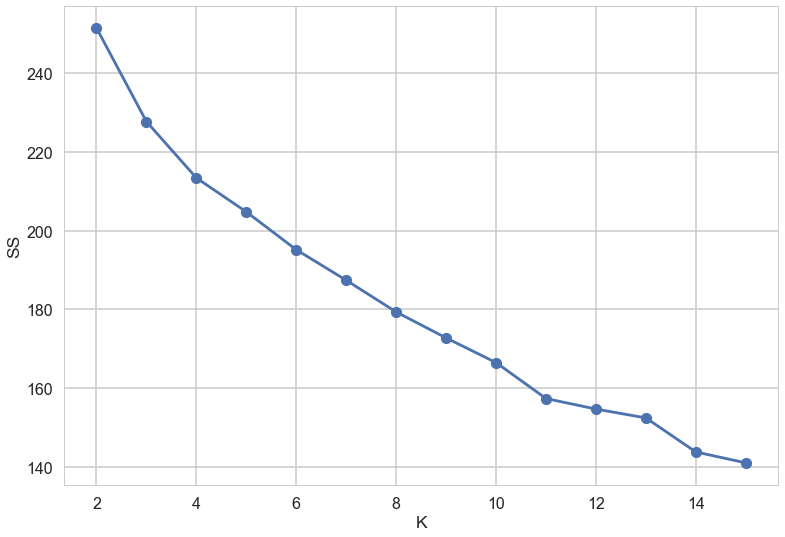

In [9]:
#Answer 4
plt.plot(ks, k_ss, 'o-')
plt.xlabel('K')
plt.ylabel('SS')
plt.show()

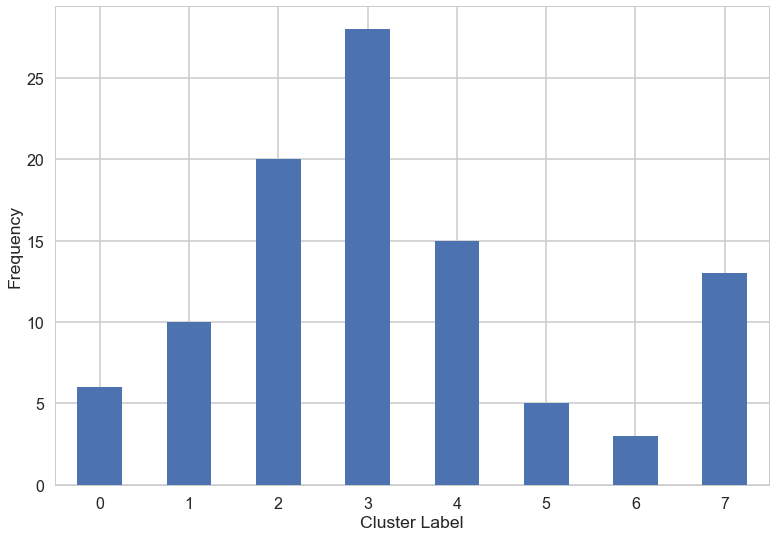

In [10]:
#Answer 5

#We choose k=8, though there is no clear answer as the elbow in the plot is very weak
kmeans = KMeans(8)
kmeans.fit(x_cols)

#Plot it (first convert to df)
pd.DataFrame(kmeans.labels_)[0].value_counts().sort_index().plot.bar()
plt.xticks(rotation=0)
plt.xlabel('Cluster Label')
plt.ylabel('Frequency')
plt.show()

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

## Set III Answers

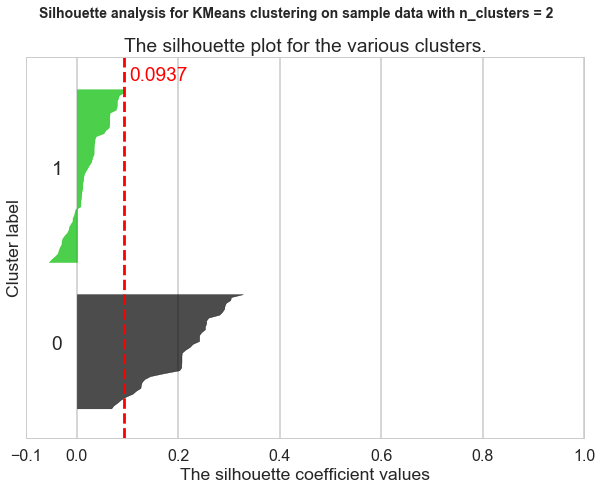

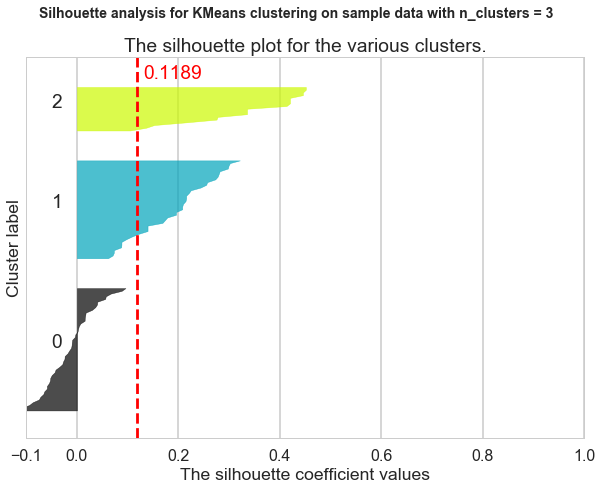

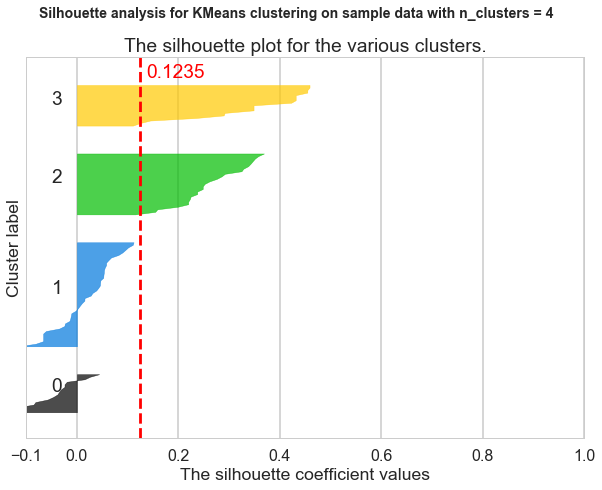

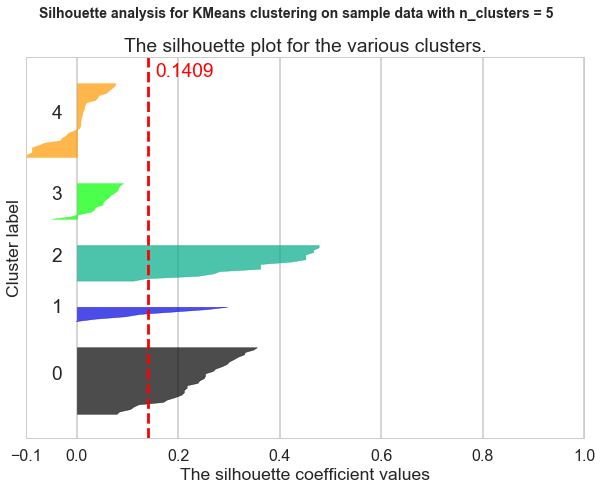

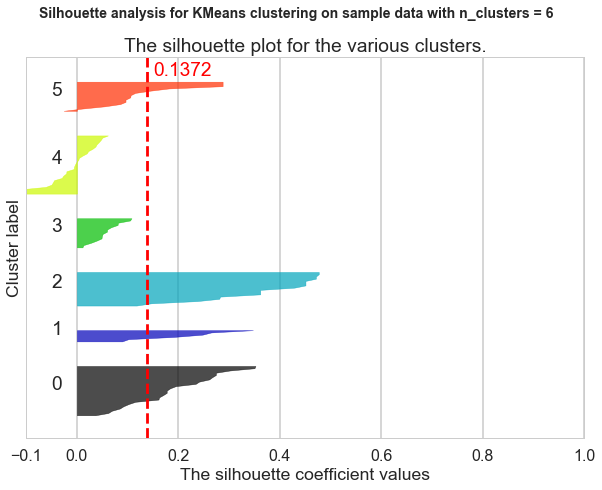

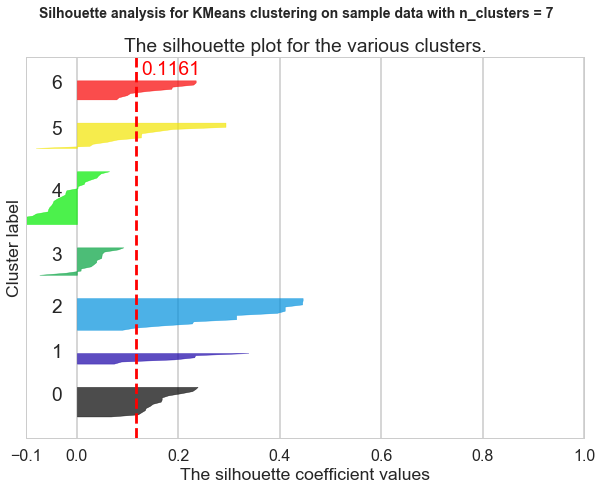

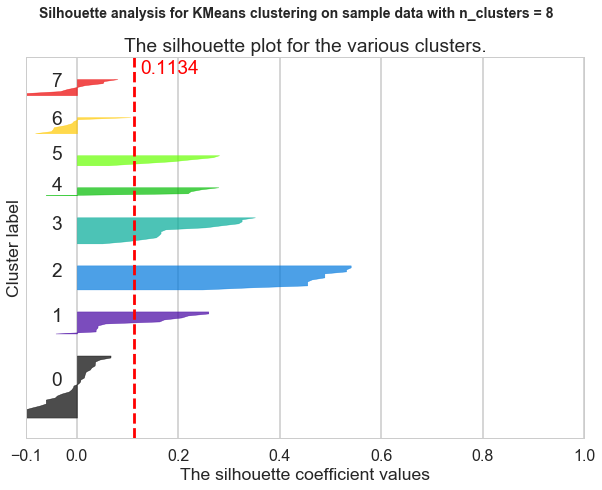

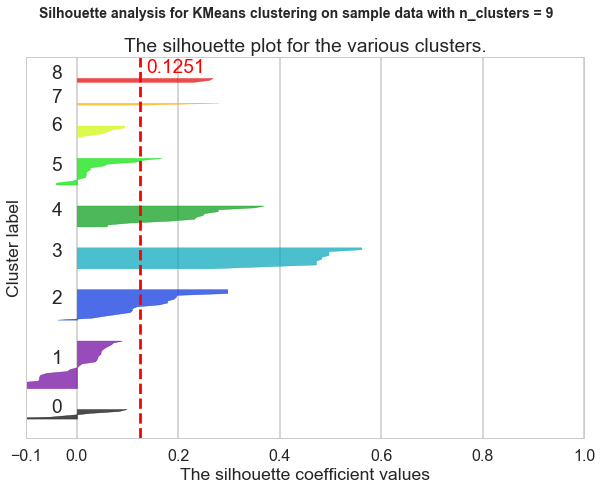

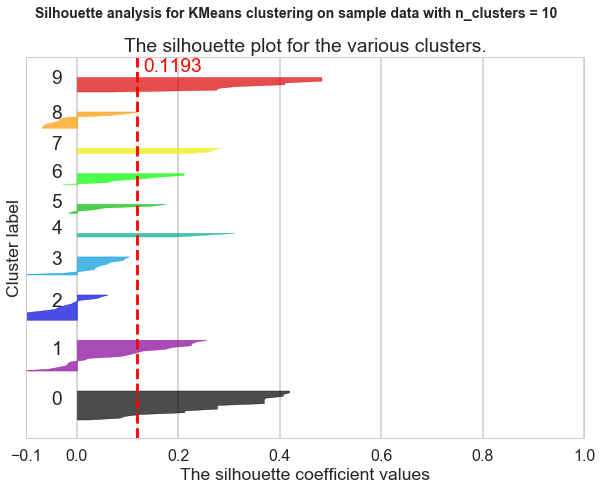

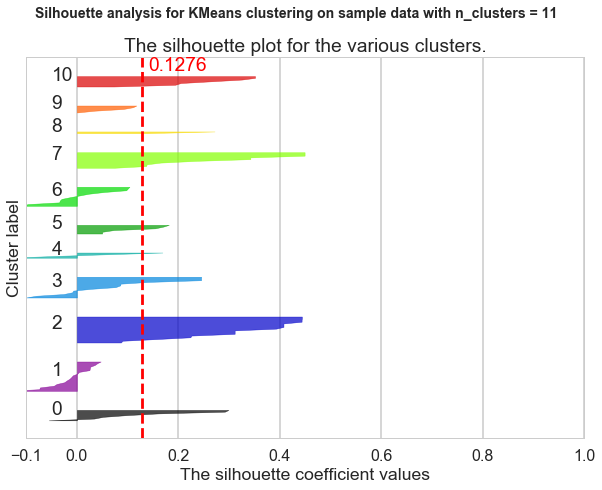

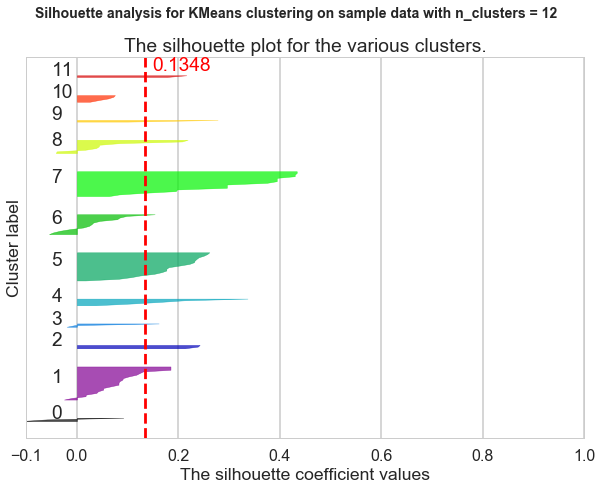

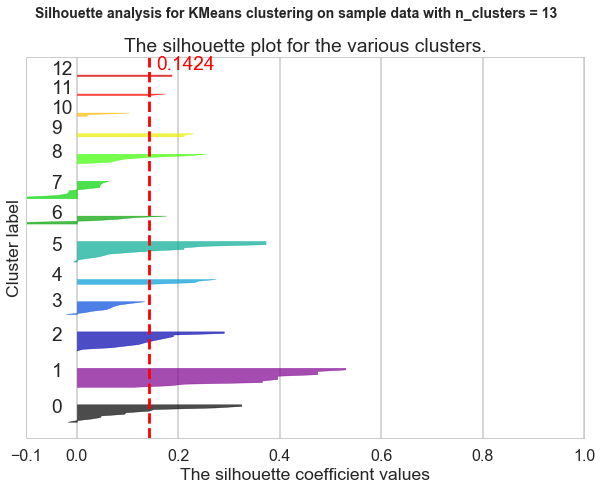

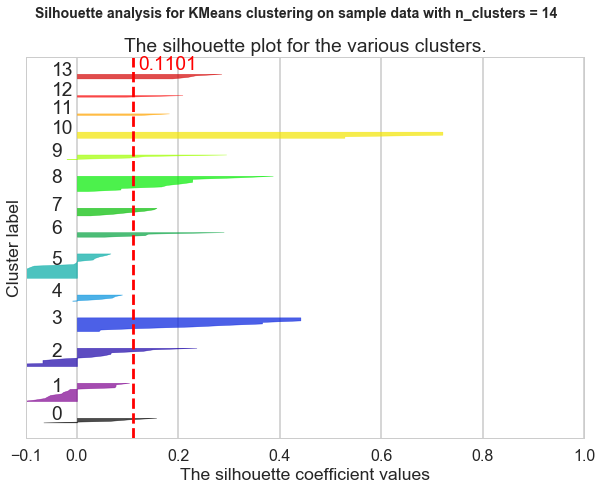

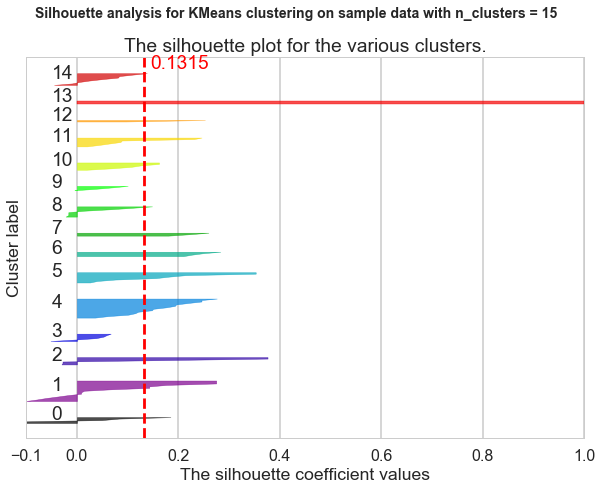

In [11]:
# Answer 1:
# Code here is adapted from:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

sil_score = []

for n_clusters in range(2,16):
    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(10, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    sil_score.append(silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, 
                         facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line/text for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.text(x=silhouette_avg*1.1, y=y_lower - 8, s='%0.4f'%silhouette_avg, color='red')

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

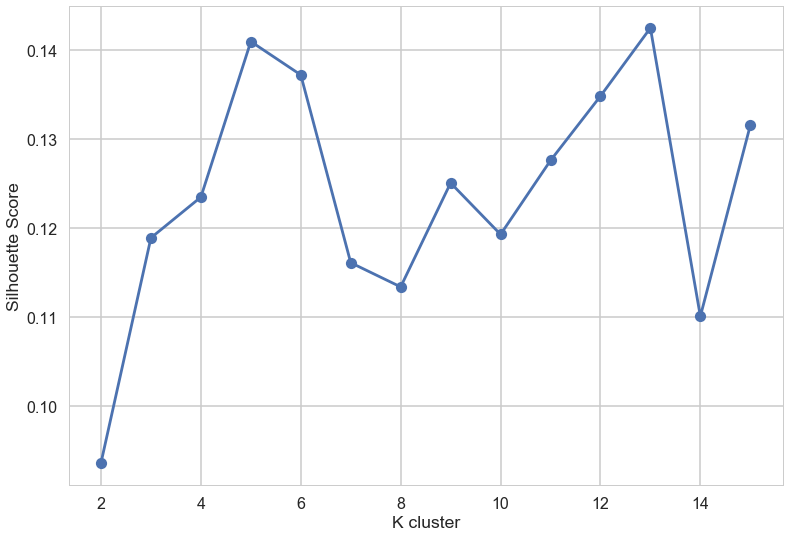

In [12]:
#Answer 2:
plt.plot(range(2,16), sil_score, 'o-')
plt.xlabel('K cluster')
plt.ylabel('Silhouette Score')
plt.show()

**Answer**: The silhouette scores are all well below 0.25 indicating poor clustering. This means it is difficult to choose a good metric. That being said, our earlier choice of K=8 is not great since there are better choices of K which have a higher silhouette score. A choice of 5 or 13 is likely better for K, though still not good. 

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

## Set IV Answers


In [13]:
# Apply PCA to the data
model = PCA(2)
transform = model.fit_transform(x_cols)

# Get new clustering for k=5
kmeans = KMeans(5)
kmeans.fit(x_cols)

# Construct customer/cluster/pca dataframe
df_pca = pd.DataFrame(df_responses.index)
df_pca['cluster'] = kmeans.labels_
df_pca['pc1'] = transform[:,0]
df_pca['pc2'] = transform[:,1]
df_pca.sample(10)

,customer_name,cluster,pc1,pc2
67,Powell,2,-0.118158,0.189875
27,Gomez,2,-0.412830,-0.012199
0,Adams,0,1.007580,0.108215
79,Russell,2,-0.273058,0.593281
12,Carter,0,1.260763,-0.014255
68,Price,3,-0.177934,-0.749716
96,Wilson,0,0.688224,-0.013688
2,Anderson,4,-0.392032,1.038391
26,Garcia,2,-0.299666,0.006964
6,Bell,4,-0.591941,1.506500


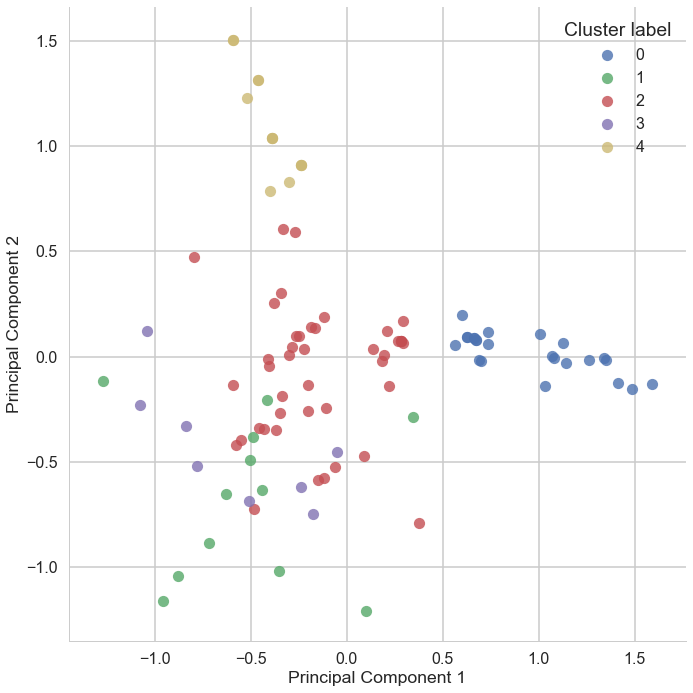

In [14]:
#Plot the clusters in PC space
sns.lmplot(data=df_pca, x='pc1', y='pc2', hue='cluster', size=10, fit_reg=False, legend=None)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster label')
plt.show()

**Answer**: From this plot it seems like there are more clusters than probably needed. There is signifant overlap between the fifth cluster (labeled as 4) with the three other clusters. This cluster can probably go away entirely. There is also more overlap between the rest of the clusters so we can perhaps even take away another cluster, though there is some differences as well so it is not as straight-forward. 

The better method of choosing K is likely the more robust silhouette method to have a good numerical estimate of the best K. 

Given our PCA, we can re-do the cluster for only 3 labels and see how it looks in our reduced dimensional space.

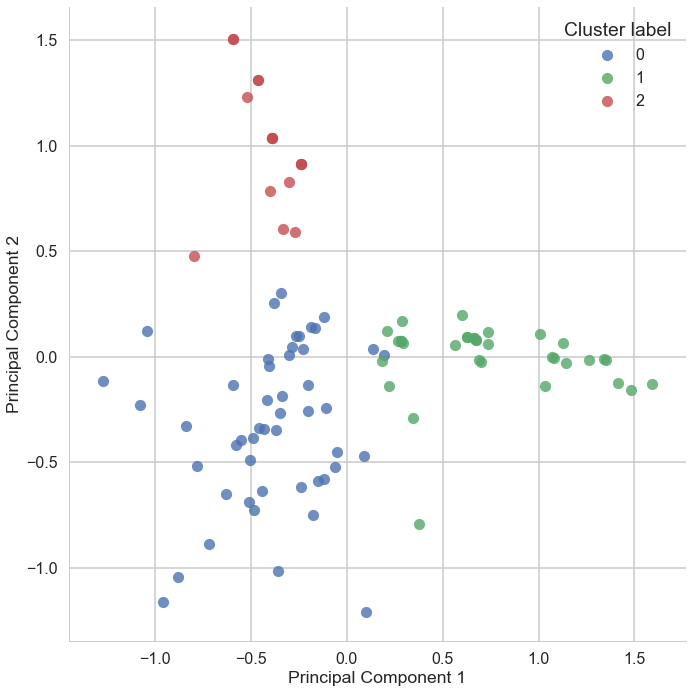

In [15]:
# Get new clustering for k=3
kmeans = KMeans(3)
kmeans.fit(x_cols)

df_pca['cluster'] = kmeans.labels_

#Plot it
sns.lmplot(data=df_pca, x='pc1', y='pc2', hue='cluster', size=10, fit_reg=False, legend=None)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster label')
plt.show()

That looks a lot better now with better, refined differences between the clusters. We can re-merge with the original data to take a look at how things might be correlated. 

In [16]:
#Add transactions
df_clusters = df_transactions.merge(df_pca, on='customer_name', right_index=True)
#Add offer details
df_clusters = df_clusters.merge(df_offers, on='offer_id')

In [17]:
#Take a look at the new dataframe
df_clusters.sample(10)

,customer_name,offer_id,n,cluster,pc1,pc2,campaign,varietal,min_qty,discount,origin,past_peak
6,Peterson,2,1,2,-0.797379,0.475995,January,Pinot Noir,72,17,France,False
199,Reed,14,1,0,-0.252065,0.100076,June,Merlot,72,64,Chile,False
62,White,22,1,0,-0.050484,-0.452883,August,Champagne,72,63,France,False
80,Miller,31,1,0,-0.957441,-1.160300,December,Champagne,72,89,France,False
90,Kelly,31,1,0,-0.504329,-0.489361,December,Champagne,72,89,France,False
73,Price,22,1,0,-0.177934,-0.749716,August,Champagne,72,63,France,False
316,Ross,21,1,1,0.210842,0.123742,August,Champagne,12,50,California,False
231,Jackson,1,1,0,-0.839578,-0.328823,January,Malbec,72,56,France,False
2,Martin,2,1,0,-0.382241,0.254034,January,Pinot Noir,72,17,France,False
267,Hall,11,1,0,-0.432958,-0.344493,May,Champagne,72,85,France,False


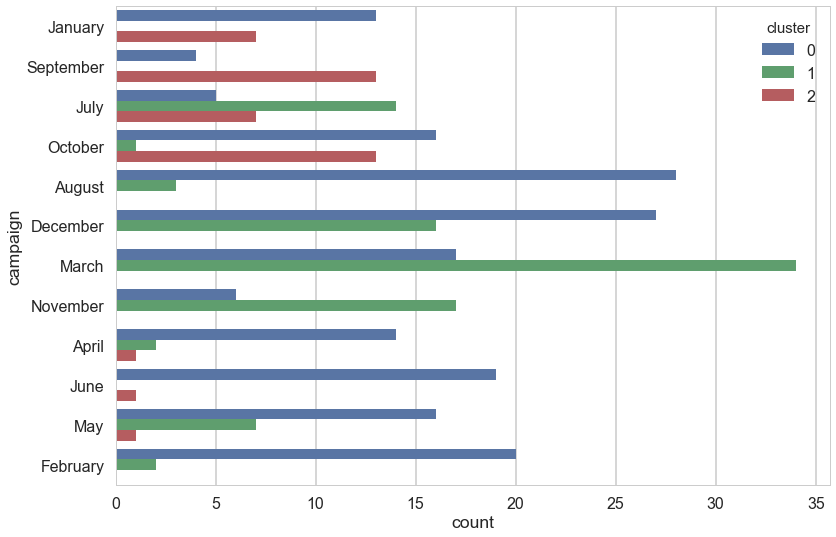

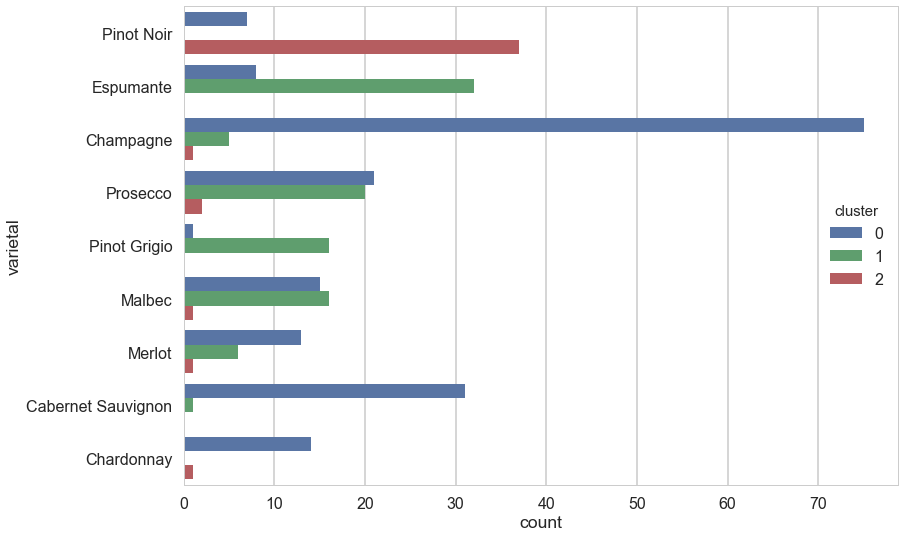

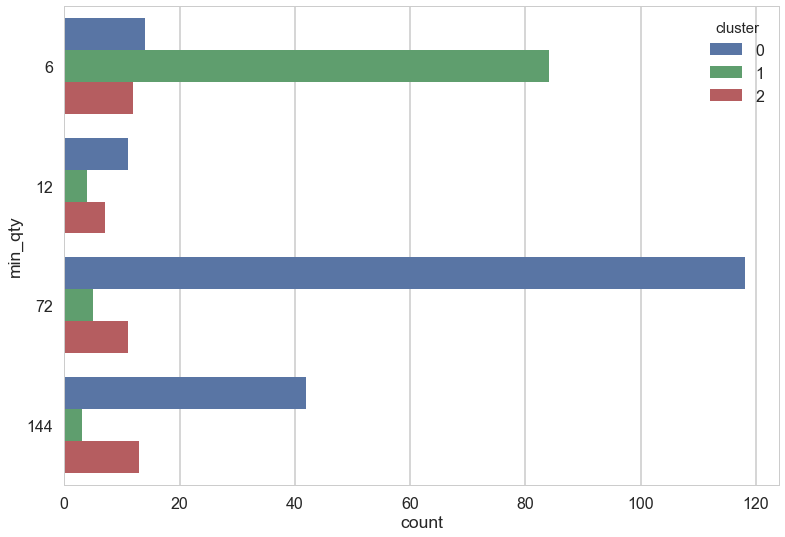

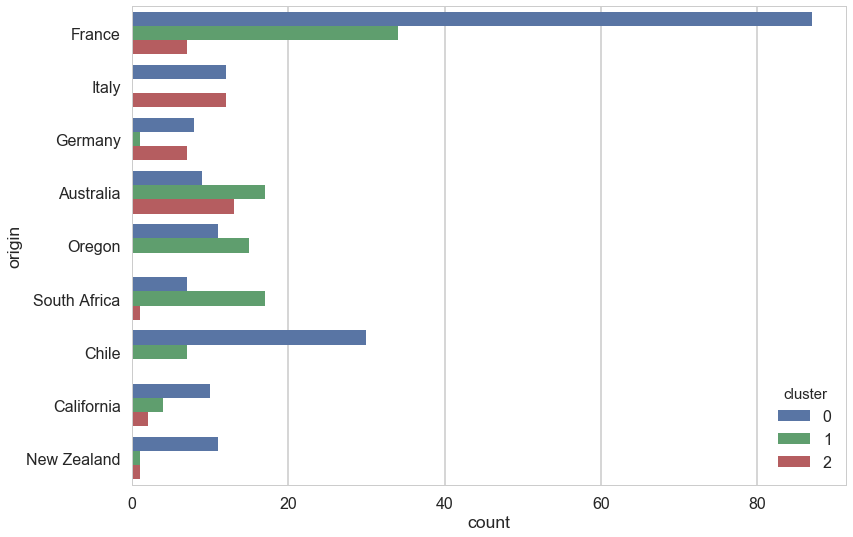

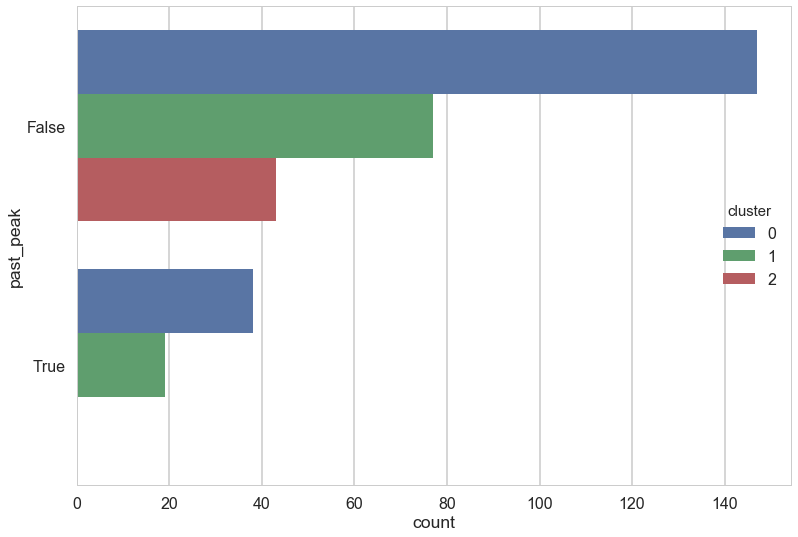

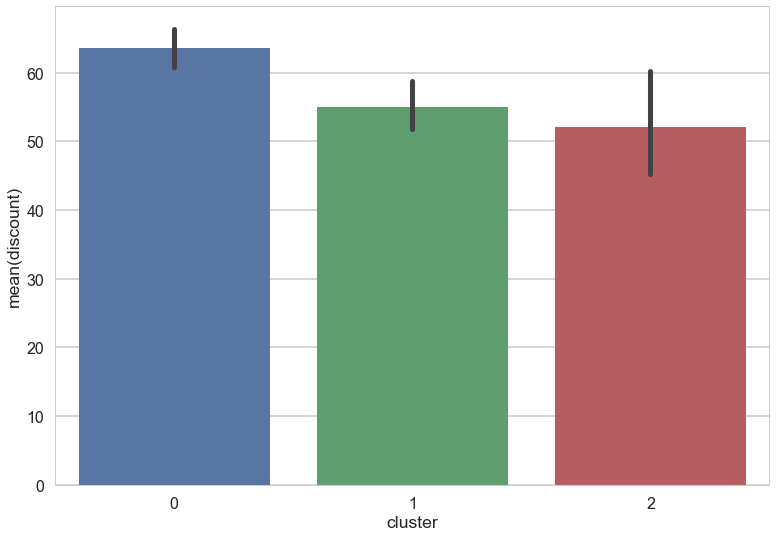

In [18]:
#Make plots for all the original features

for var in ['campaign', 'varietal', 'min_qty', 'origin', 'past_peak']:
    sns.countplot(data=df_clusters, y=var, hue='cluster')
    plt.show()
    
sns.barplot(data=df_clusters, y='discount', x='cluster')
plt.show()    

**Answer**:  There are some clear differences between the three groups of people. People in the third cluster (label 2; color red) always buy Pinot Noir that is never past its peak in certain months of the year, presumbly when the wines are best. Further they only buy those wines from Europe or Austrailia and buy at lower discount levels than others. The people in the second cluster (label 1; color green) like wine, a lot. They buy nearly all types of wine, all year long from all corners of the world. They also are the only ones buying Champagne. They also seem to buy at higher discount levels than others, perhaps owing to the large numbers of wine they order. The first cluster of people (label 0; color blue) are different from the other two in the following ways. They buy in certain months (more than the third cluster), and also at the smallest levels. They rarely make big purchases. They also like many different types of wine, but not all of them. 

The principal components then seem to represent wine type (first component) and order size (second component). The third cluster (red) is in a small group of the x dimension away from the other two: showing they only like one wine type. And the first cluster (blue) is very near 0 of the y dimension: showing they only buy at small quantities. The second cluster as a group spans both dimensions in large segments showing the large quantities of lots of different wine types they buy.

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

## Set V Answers

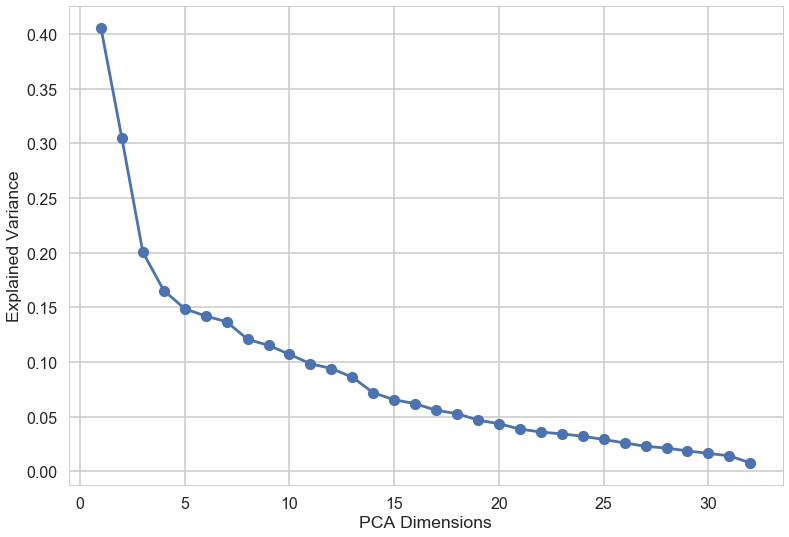

In [19]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :)
plt.plot(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_, 'o-')
plt.xlabel('PCA Dimensions')
plt.ylabel('Explained Variance')
plt.show()

**Answer** The elbow on this plot seems to be around 4. This is where there is the steepest descent and it slows down considerably after that. 

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


## Set VI Answer

There are four algorithms to try. We'll do spectral and agglomerative clustering first because the other two do take number of cluster as input. This way we will scan over the possible clusters and determine the best silhouette score.

In [20]:
#Needed vars
krange = range(2,16)
sc_score, ac_score = [], []

In [21]:
#Convenient functions 

#Fit a clustering model and plot in the PC space
def cluster_model(model, title):
    #Fit the model
    model.fit(x_cols)
    
    #Make a df for the new clustering
    df_model = pd.DataFrame({'label' : model.labels_})
    df_model['customer_name'] = df_responses.index
    df_model = df_pca.merge(df_model, on='customer_name')
    
    #Plot the clusterings in the PC space
    sns.lmplot(data=df_model, x='pc1', y='pc2', hue='label', size=10, fit_reg=False)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()
    
#Plot silhouette vs cluster plot and return the best values    
def plot_ss(scores, title):
    #Find the best silhouette score
    nscores = np.array(scores)
    index = np.where(nscores == nscores.max())
    best = krange[index[0][0]]
    
    #Plot the scores
    plt.figure(figsize=(7,4))    
    plt.plot(krange, scores, 'o-')
    plt.title(title)
    plt.xlabel('K Cluster')
    plt.ylabel('Silhouette Score')
    plt.axvline(x=best, color='red', ls='--')
    plt.show()
    
    #Return the best cluster and score
    return(best, nscores.max())

In [22]:
#Go through spectral and agglomerative
for k in krange:
    #Spectral
    sc = SpectralClustering(k)
    pred = sc.fit_predict(x_cols)
    score = silhouette_score(x_cols, pred)
    sc_score.append(score)
    
    #Agglomerative
    ac = AgglomerativeClustering(k)
    pred = ac.fit_predict(x_cols)
    score = silhouette_score(x_cols, pred)
    ac_score.append(score)

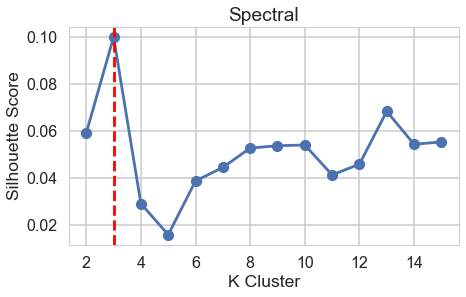

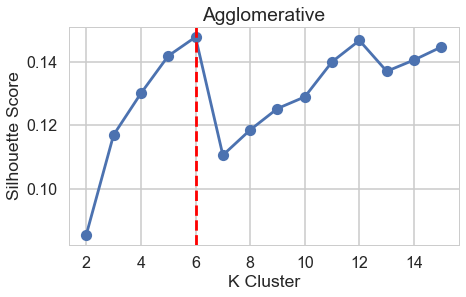

In [23]:
#Get the scores for various cluster sizes
k_sc, score_sc = plot_ss(sc_score, 'Spectral')
k_ac, score_ac = plot_ss(ac_score, 'Agglomerative')   

With the best cluster sizes for the spectral and agglomerative algorithms, we can focus on the next two. The DBSCAN actually takes two parameters, with none being cluster size. So we can use a grid search across these values to get the best DBSCAN. Since we are using silhouette score as the metric to compare models, we use it as the scoring method to optimize. We can loop over the probable values for the algorithm and determine the best combination.

In [24]:
#DBSCAN grid search
grid_eps = np.linspace(0.01, 100, 1000)
grid_min_samp = krange

db_best_score, db_best_eps, db_best_min = -1, 0, 0
for e in grid_eps:
    for m in grid_min_samp:
        labels = DBSCAN(eps=e, min_samples=m).fit_predict(x_cols)
        
        #Make sure there is more than one cluster
        if len(set(labels)) > 1:
            score = silhouette_score(x_cols, labels)
        else:
            score = -100
        
        #Save best combination
        if score > db_best_score:
            db_best_score = score
            db_best_eps = e
            db_best_min = m

print('DBSCAN: best score = %f, best eps = %f and best min_samples = %i' % (db_best_score, db_best_eps, db_best_min))

DBSCAN: best score = 0.279223, best eps = 2.312072 and best min_samples = 7


We can see the optimal parameters are about an eps of 2.3 and min_samples of 15. Let's create a new DBSCAN object and get the optimized model fitted.

In [25]:
db = DBSCAN(eps=db_best_eps, min_samples=db_best_min)
labels = db.fit_predict(x_cols)

k_db = np.sum(labels*-1)
score_db = silhouette_score(x_cols, labels)

The Affinity algorithm is similar in that we will need to search over the damping parameter instead of the cluster size. So we can do this 1-D search loop-wise too. 

In [26]:
#Affinity grid search
grid_damp = np.linspace(0.5, 0.99, 99)

ap_best_score, ap_best_damp = -1, 0
for d in grid_damp:
    labels = AffinityPropagation(damping=d).fit_predict(x_cols)

    #Make sure there is more than one cluster
    if len(set(labels)) > 1:
        score = silhouette_score(x_cols, labels)
    else:
        score = -100
        
    #Save best combination
    if score > ap_best_score:
        ap_best_score = score
        ap_best_damp = d

print('Affinity: best score = %f and best damping = %f' % (ap_best_score, ap_best_damp))

Affinity: best score = 0.123465 and best damping = 0.500000


Interestingly, the default is the best value to use! Ok, now we have our optimized Affinity model.

In [27]:
af = AffinityPropagation(damping=ap_best_damp)
af.fit(x_cols)

k_af = len(af.cluster_centers_indices_)
score_af = silhouette_score(x_cols, af.labels_)

This gives us best models for all four algorithms. Now we can also visualize all four algorithms and their clustering in our principal component space, as we did with the KMeans algorithm previously. This can help us better understand what is happening.

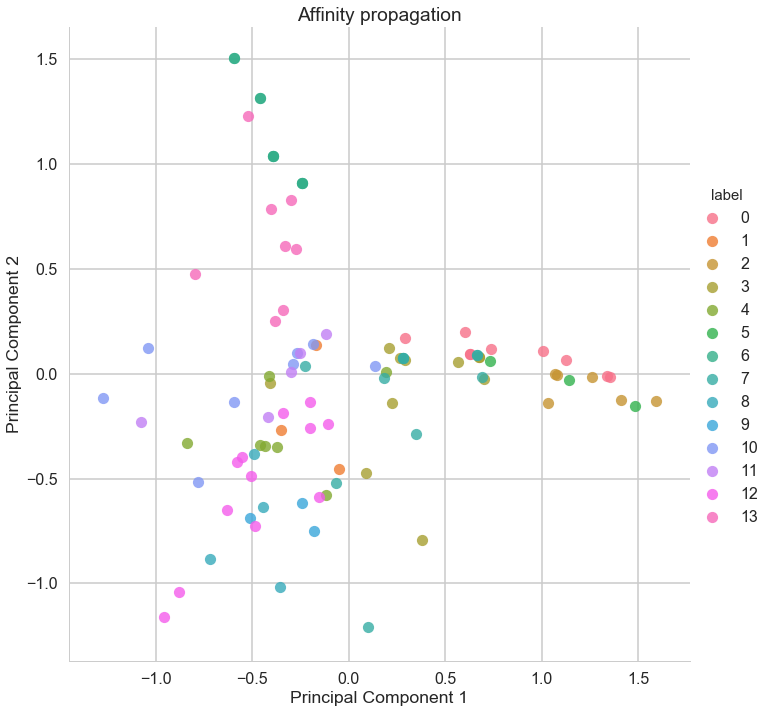

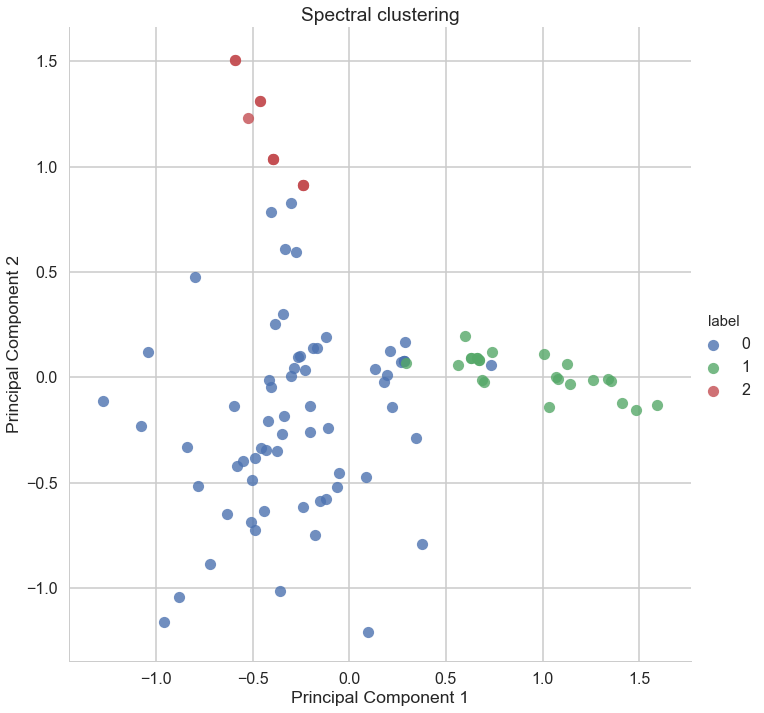

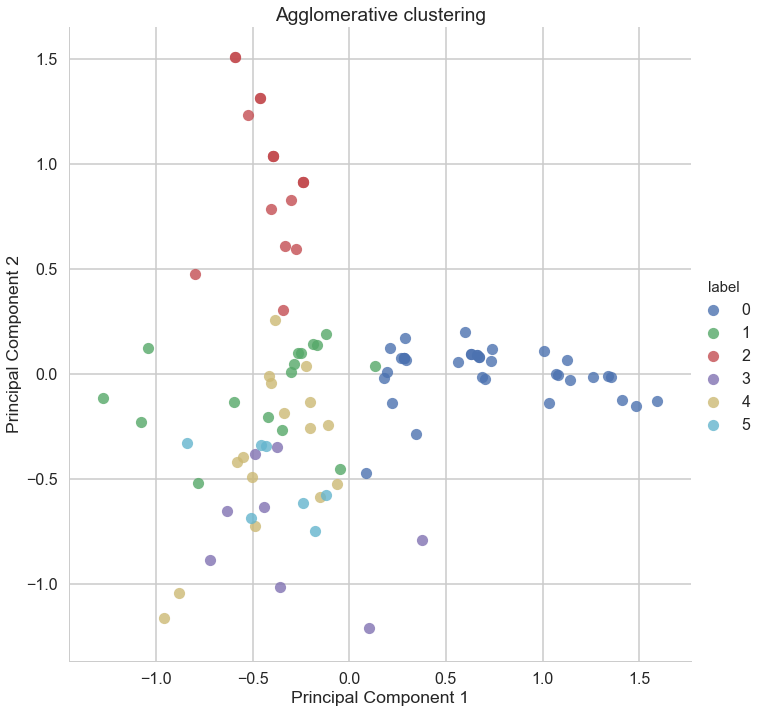

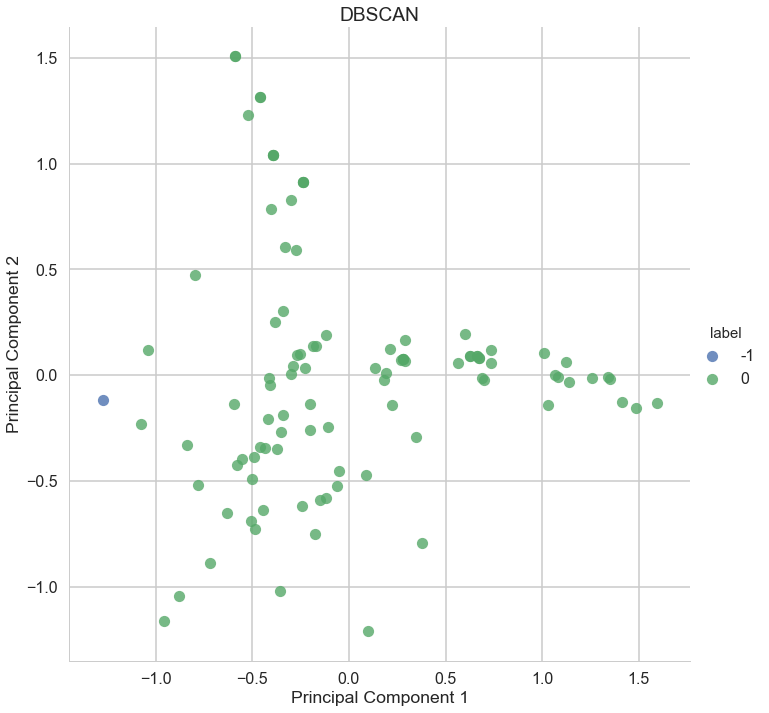

In [28]:
cluster_model(af, 'Affinity propagation')
cluster_model(SpectralClustering(k_sc), 'Spectral clustering')
cluster_model(AgglomerativeClustering(k_ac), 'Agglomerative clustering')
cluster_model(db, 'DBSCAN')

We see how the different algorithms do different groupings. Since we used the silhouette score as the metric of choice to compare our models, let's do that. Since we used K-means earlier, we should include it in this comparison as well.

In [29]:
#Use sil_score which has our kmeans scores
index = np.where(np.array(sil_score) == np.array(sil_score).max())
best = krange[index[0][0]]

k_km = best
score_km = np.max(sil_score)

In [30]:
print('%-25s : %3.0f clusters \t %2.4f silhouette score' % ('Affinity propagation',     k_af, score_af))
print('%-25s : %3.0f clusters \t %2.4f silhouette score' % ('Spectral clustering',      k_sc, score_sc))
print('%-25s : %3.0f clusters \t %2.4f silhouette score' % ('Agglomerative clustering', k_ac, score_ac))
print('%-25s : %3.0f clusters \t %2.4f silhouette score' % ('DBSCAN',                   k_db, score_db))
print('%-25s : %3.0f clusters \t %2.4f silhouette score' % ('K-means',                  k_km, score_km))

Affinity propagation      :  14 clusters 	 0.1235 silhouette score
Spectral clustering       :   3 clusters 	 0.0999 silhouette score
Agglomerative clustering  :   6 clusters 	 0.1479 silhouette score
DBSCAN                    :   1 clusters 	 0.2792 silhouette score
K-means                   :  13 clusters 	 0.1424 silhouette score


**Answer**: From here it seems the DBSCAN is the clear winner, nearly doubling its closest competitor. However, it is an algorithm  that does not assign anything to clusters and instead just uses density. So we perhaps should not use it. In that case we probably use Agglomerative clustering. It has a very similar score to K-means, but it has fewer clusterings. I think that is more desirable since it is more interpretable, which is the ultimate purpose of this type of exercise. 

However, this is not a complete analysis. We have restricted ourselves to just a two dimensional PCA. We found out earlier that four dimensional PCA is likely the best version to use. In that case we should repeat everything we have done for that case and check the outcomes of the algorithms. Additionally, I used silhouette score as the metric when there are other metrics out there, including the gap statistic, which might be better. These limitations should be kept in mind as we move forward. 

-------------

Et fin.